In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite
import pandas as pd

In [ ]:
def degree(g, nodes=None, as_list=True):
    deg = None
    if nodes:
        deg = dict(g.degree(nodes))
    else:
        deg = dict(g.degree())
    
    if as_list:
        return list(deg.values())
    return deg

def degree_plot(g, nodes, title=''):
    deg = degree(g, nodes)
    bins = 100
    if len(nodes) < 100:
        bins = len(nodes)
    hist = np.histogram(deg, bins=bins)
    v = range(min(deg), max(deg)+1)
    freqs, edges = hist[0], hist[1]
    n = freqs.size
    means = [(edges[i] + edges[i+1]) / 2 for i in range(n)]
    
    # SCATTER PLOT
    plt.plot(means, freqs, ".")
    plt.xlabel("k")
    plt.ylabel("frequency")
    plt.title("Degree distribution for %s" % title)
    plt.show()
    
    # LOG LOG PLOT
    plt.loglog(means, freqs, ".")
    plt.xlabel("log(k)")
    plt.ylabel("log(frequency)")
    plt.title("Log-log degree distribution for %s" % title)
    plt.show()

In [5]:
USER = 'user'
BIZ = 'biz'
TORONTO = 'toronto'

In [89]:
biz = pd.read_csv('toronto/biz_coffee.csv').drop('Unnamed: 0', axis=1)
user = pd.read_csv('toronto/users.csv').drop('Unnamed: 0', axis=1)
reviews = pd.read_csv('toronto/reviews.csv').drop('Unnamed: 0', axis=1)

In [90]:
print('Reviews:', len(reviews))
print('Users:', len(set(reviews.business_id)))
print('Businesses:', len(set(reviews.user_id)))

Reviews: 6832
Users: 824
Businesses: 4276


### Creating the network

In [12]:
# A node class for storing data.
class Node:
    def __init__(self, Data, Type):
        self.Data = Data
        self.Type = Type
    
    def to_string(self):
        return "Node (%s), Data: " % (self.Type, self.Data)
    
    def __hash__(self):
        return hash(self.Data)
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.Data == other.Data
               )

In [13]:
graph = nx.Graph()
for row in reviews.itertuples():
    b = Node(row.business_id, BIZ)
    u = Node(row.user_id, USER)
    graph.add_edge(u, b)

In [14]:
print('Nodes:', len(graph.nodes()))
print('Edges:', len(graph.edges()))

Nodes: 5100
Edges: 6832


### Degree Dist

In [15]:
biz_nodes = [n for n in list(graph.nodes()) if n.Type == BIZ]
user_nodes = [n for n in list(graph.nodes()) if n.Type == USER]

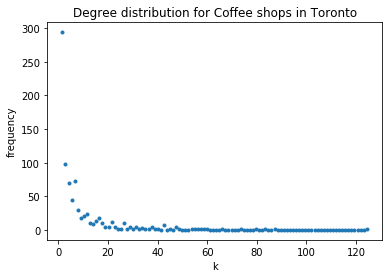

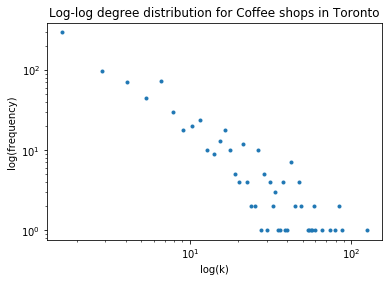

In [16]:
degree_plot(graph, biz_nodes, "Coffee shops in Toronto")

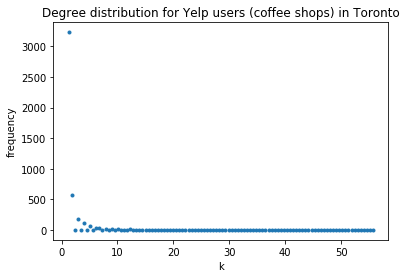

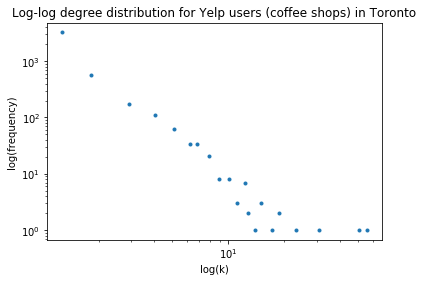

In [17]:
degree_plot(graph, user_nodes, "Yelp users (coffee shops) in Toronto")

### Eigenvector Centrality

In [18]:
ev_centrality = nx.eigenvector_centrality_numpy(graph)
sorted_ev_centrality = sorted(ev_centrality.items(), key=lambda x: x[1], reverse=True)
ev_biz = [(n, ev) for (n, ev) in sorted_ev_centrality if n.Type == BIZ]
ev_user = [(n, ev) for (n, ev) in sorted_ev_centrality if n.Type == USER]

In [19]:
ev_biz[:5]

[(<__main__.Node at 0xa2087f780>, 0.45160198921391304),
 (<__main__.Node at 0xa2086f7b8>, 0.21939803140493588),
 (<__main__.Node at 0xa2087aef0>, 0.1395458141930534),
 (<__main__.Node at 0xa208496a0>, 0.13200976663234915),
 (<__main__.Node at 0xa2086bef0>, 0.12485227342571599)]

In [101]:
for (n,e) in ev_user[:20]:
    user_id = n.Data
    u = user[user.user_id == user_id]
    print(u.name.iloc[0], u.elite.iloc[0])

Soleil 2012, 2013, 2014, 2017, 2016, 2015, 2018
Owen 2017, 2018
Jennifer 2015, 2012, 2010, 2018, 2009, 2014, 2013, 2011, 2016, 2017
Michelle None
Alice 2016, 2017, 2018
Tomoko 2018, 2017
Wendy 2017, 2018
Min 2016, 2018, 2014, 2015, 2017
Sam 2017
Jane 2016, 2018, 2017
Shoshana None
Ada 2018, 2016, 2017
Danielle 2018, 2017
Chris 2016, 2018, 2017
Amy 2018, 2015, 2017, 2016, 2014
L None
Angel 2017, 2018
Jen None
Kris 2016, 2015, 2012, 2018, 2013, 2014, 2017
Vince 2017, 2018


In [23]:
for i in range(20):
    b = biz[biz.business_id == ev_biz[i][0].Data]
    print(list(b.name))

['Sweet Jesus']
['Strange Love']
['Dineen Coffee']
['Sud Forno']
['Quantum Coffee']
['Oretta']
['HotBlack Coffee']
['BlackGold Cafe']
['Petit Potato']
['Fahrenheit Coffee']
['Early Bird Coffee & Kitchen']
['Calii Love']
['Le Gourmand']
['Bannock']
['Plentea']
['Death in Venice Gelato']
['Roselle']
['NEO COFFEE BAR']
['Portland Variety']
['Colette Grand Cafe']


### Plotting the subgraph

* Filter out reviewers who have only reviewed one coffee shop.
* Filter out businesses with only 1 review

In [54]:
top_reviews = reviews.groupby("user_id").filter(lambda x: len(x) > 1)
top_reviews = top_reviews.groupby("business_id").filter(lambda x: len(x) > 5)
print('Reviews:', len(top_reviews))
print('Users:', len(set(top_reviews.user_id)))
print('Businesses:', len(set(top_reviews.business_id)))

Reviews: 2515
Users: 952
Businesses: 189


In [60]:
sub_graph = nx.Graph()
for row in top_reviews.itertuples():
    b = Node(row.business_id, BIZ)
    u = Node(row.user_id, USER)
    sub_graph.add_edge(u, b)

In [61]:
nodes = sub_graph.nodes()
degrees = 5 * np.array(degree(sub_graph))
color_map = []
for p in nodes:
    if p.Type == USER: 
        color_map.append("green")
    elif p.Type == BIZ: 
        color_map.append("purple")
    else: 
        color_map.append("#black")

In [62]:
from fa2l import force_atlas2_layout
positions = force_atlas2_layout(sub_graph,
                                iterations=5,
                                pos_list=None,
                                node_masses=None,
                                outbound_attraction_distribution=False,
                                lin_log_mode=False,
                                prevent_overlapping=False,
                                edge_weight_influence=1.0,

                                jitter_tolerance=1.0,
                                barnes_hut_optimize=False,
                                barnes_hut_theta=0.5,

                                scaling_ratio=2.0,
                                strong_gravity_mode=False,
                                multithread=False,
                                gravity=1.0)

/Users/tnni/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/tnni/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


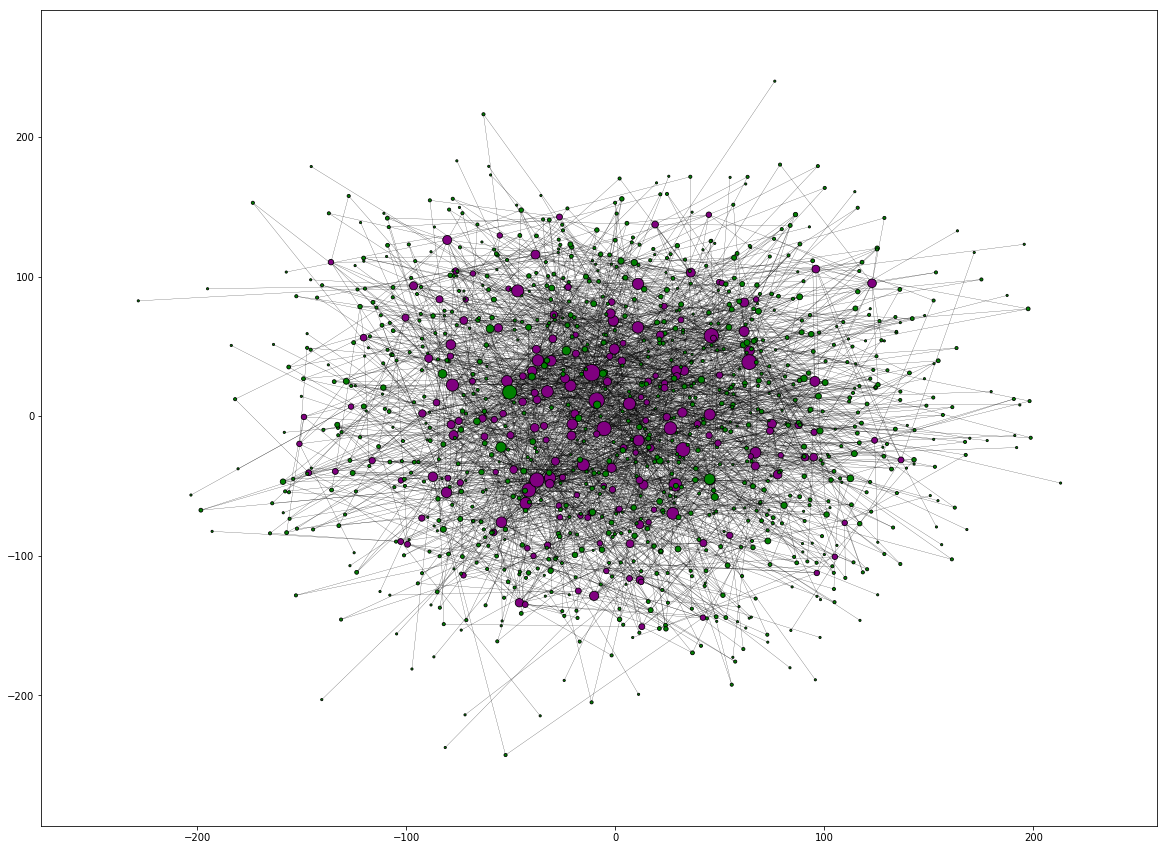

In [59]:
plt.figure(figsize=[20,15])
nx.draw_networkx(sub_graph, positions, with_labels=False, node_color=color_map, node_size=degrees, width=0.15, linewidths=0.8)
plt.gca().collections[0].set_edgecolor("#000000") 
plt.show()